In [1]:
import random

import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.layers import Dense, LSTM, Bidirectional, Activation, Embedding, Conv1D, Flatten
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import TensorBoard
import matplotlib.pyplot as plt
from datetime import datetime


from dataprocessing.find_top_movie_with_sequence import find_top_dataset
from dataprocessing.label_and_feature import getSortedClassContents, checkConsists, buildFeature, saveClassesToFile
from dataprocessing.time import checkingTimeDifferent
from recom_model import trainWithBidirectional,trainWithEmbeddingDense

[[[[0, 0, 2]], 4], [[[0, 0, 1]], 1], [[[0, 0, 3]], 5], [[[0, 0, 4]], 7], [[[0, 3, 1]], 3]]


In [2]:
MIN_CONTENTS_ON_USER = 250
MAX_DAYS = 7
MAX_SEQUENCE = 1
DATA_DIR = "data"

recommandation_df = pd.read_csv('{}/data.csv'.format(DATA_DIR)).sort_values(by=['time'])

In [3]:
sortedClassContents = getSortedClassContents(recommandation_df, MIN_CONTENTS_ON_USER)
saveClassesToFile(sortedClassContents)
lenSortedClassContents = len(sortedClassContents)
print(lenSortedClassContents)

[0, 1, 11, 12, 15, 16, 17, 20, 22, 23, 26, 29, 30, 39, 41, 49, 51, 54, 55, 61, 65, 66, 67, 68, 69, 79, 84, 87, 91, 95, 97, 101, 102, 104, 106, 107, 108, 115, 117, 121, 123, 125, 126, 128, 131, 133, 135, 138, 139, 140, 141, 143, 147, 148, 158, 161, 162, 163, 167, 169, 172, 175, 176, 181, 186, 188, 194, 195, 199, 202, 205, 206, 207, 208, 211, 213, 224, 225, 226, 227, 228, 231, 232, 238, 245, 247, 250, 251, 252, 255, 259, 263, 264, 268, 270, 271, 278, 280, 284, 285, 286, 287, 288, 294, 296, 299, 300, 302, 303, 306, 308, 312, 314, 315, 322, 329, 331, 332, 333, 334, 338, 343, 345, 347, 348, 350, 351, 355, 358, 361, 369, 370, 371, 372, 376, 379, 388, 389, 390, 397, 410, 415, 416, 421, 422, 423, 425, 426, 433, 434, 438, 440, 441, 448, 449, 452, 455, 460, 475, 478, 479, 480, 481, 482, 484, 485, 487, 492, 507, 512, 513, 514, 522, 535, 541, 542, 548, 593, 596, 598, 621, 622, 623, 624, 626, 627, 631, 634, 640, 642, 644, 649, 652, 654, 655, 657, 659, 662, 663, 665, 667, 678, 681, 682, 683, 684, 69

In [4]:
def build_training_data(data_frame):
    # datetime object containing current date and time
    now = datetime.now()

    print("start =", now)

    visitors_df = data_frame['visitor'].drop_duplicates()
    maxItem = data_frame['Content'].max()
    training_data = []
    for index, item in visitors_df.iteritems():
        video = data_frame[data_frame['visitor'] == item]
        if video.size > 1:
            tempContents = []
            indexContent = 0
            for index, item in video['Content'].iteritems():
                if item not in sortedClassContents:
                    continue
                if len(tempContents) > MAX_SEQUENCE:
                    tempContents = tempContents[1:]
                    continue
                if checkConsists(item, tempContents):
                    continue
                if len(tempContents) > 0:
                    feature = buildFeature(tempContents, sortedClassContents, MAX_SEQUENCE)
                    label = sortedClassContents.index(item)
                    training_data.append([[feature], label])
                tempContents.append(item)
                indexContent += 1

    now = datetime.now()
    print("end =", now)
    return training_data

In [5]:
data1 = pd.read_csv('{}/data1.csv'.format(DATA_DIR)).sort_values(by=['time'])
training_data = build_training_data(data1)

start = 2020-11-15 20:05:24.959407
end = 2020-11-15 20:34:30.132987


In [6]:
data2 = pd.read_csv('{}/data2.csv'.format(DATA_DIR)).sort_values(by=['time'])
training_data = np.concatenate((training_data, build_training_data(data2)))

start = 2020-11-15 20:36:07.420930
end = 2020-11-15 21:23:09.738373


In [12]:
def saveDatas(datas):
    features = []
    labels = []
    for feature, label in datas:
        features.append(feature)
        labels.append(label)

    a_file = open('{}/backup_features.txt'.format(DATA_DIR), "w")
    for row in features:
        np.savetxt(a_file, row[0])
    a_file.close()

    a_file = open('{}/backup_labels.txt'.format(DATA_DIR), "w")
    np.savetxt(a_file, labels)
    a_file.close()

In [11]:
saveDatas(training_data)

In [13]:
print('{}.before', len(training_data))
data3 = pd.read_csv('{}/data3.csv'.format(DATA_DIR)).sort_values(by=['time'])
training_data = np.concatenate((training_data, build_training_data(data3)))
print(len(training_data))
saveDatas(training_data)

{}.before 76435
start = 2020-11-15 21:28:37.896403
end = 2020-11-15 22:01:24.047751
112152


In [14]:
data4 = pd.read_csv('{}/data4.csv'.format(DATA_DIR)).sort_values(by=['time'])
training_data = np.concatenate((training_data, build_training_data(data4)))
print(len(training_data))
saveDatas(training_data)

start = 2020-11-15 22:01:26.632021
end = 2020-11-15 22:14:30.261465
137968


In [15]:
data5 = pd.read_csv('{}/data5.csv'.format(DATA_DIR)).sort_values(by=['time'])
training_data = np.concatenate((training_data, build_training_data(data5)))
print(len(training_data))
saveDatas(training_data)

start = 2020-11-15 22:14:33.465007
end = 2020-11-15 22:31:09.661152
165410


In [16]:
data6 = pd.read_csv('{}/data6.csv'.format(DATA_DIR)).sort_values(by=['time'])
training_data = np.concatenate((training_data, build_training_data(data6)))
print(len(training_data))
saveDatas(training_data)

start = 2020-11-15 22:31:13.390745
end = 2020-11-15 22:50:38.308230
189959


In [17]:
validation_data = find_top_dataset(training_data)
print("training size: ", len(training_data))
print("validation size: ", len(validation_data))
# print(training_data)
print("-------------------------")
# print(validation_data)
random.shuffle(training_data)


training size:  189959
validation size:  694
-------------------------


In [39]:
features = []
labels = []
for feature, label in training_data:
    features.append(feature)
    labels.append(label)

In [44]:
X = np.array(features)
Y = np.array(labels)
print(X.shape)



(189959, 1, 1)


In [41]:
features_val = []
labels_val = []
for feature, label in validation_data:
    features_val.append(feature)
    labels_val.append(label)

X_val = np.array(features_val)
Y_val = np.array(labels_val).astype(np.float32)

In [45]:
# for cnn
X = np.squeeze(X, axis=1)
print(X.shape)
model = Sequential()   
model.add(Dense(1024, activation="relu", input_shape=(X.shape[1:])))
model.add(Dense(1024, activation="relu"))
model.add(Dense(1024, activation="relu"))
model.add(Dense(1024, activation="relu"))
model.add(Dense(1024, activation="relu"))
model.add(Dense(1024, activation="relu"))
model.add(Dense(lenSortedClassContents))
model.add(Activation("softmax"))
model.compile(loss='sparse_categorical_crossentropy', optimizer="adam", metrics=['accuracy'])


(189959, 1)


In [ ]:
# for embedding Dense
X = np.squeeze(X, axis=1)
model = trainWithEmbeddingDense(MAX_SEQUENCE, lenSortedClassContents)

In [46]:
now = datetime.now()
name = "testing-1{}".format(now)
tensorboard = TensorBoard(log_dir='logs/{}'.format(name))
history = model.fit(X, Y, epochs=256, batch_size=64, verbose=1,validation_data=(X_val, Y_val), callbacks=[tensorboard])

Epoch 1/256
2969/2969 [==============================] - 17s 6ms/step - loss: 6.0920 - accuracy: 0.0204 - val_loss: 6.0007 - val_accuracy: 0.0231
Epoch 2/256
2969/2969 [==============================] - 16s 6ms/step - loss: 5.9766 - accuracy: 0.0244 - val_loss: 5.8243 - val_accuracy: 0.0288
Epoch 3/256
2969/2969 [==============================] - 17s 6ms/step - loss: 5.9157 - accuracy: 0.0282 - val_loss: 5.7171 - val_accuracy: 0.0303
Epoch 4/256
2969/2969 [==============================] - 17s 6ms/step - loss: 5.8666 - accuracy: 0.0304 - val_loss: 5.5805 - val_accuracy: 0.0476
Epoch 5/256
2969/2969 [==============================] - 18s 6ms/step - loss: 5.8245 - accuracy: 0.0331 - val_loss: 5.5070 - val_accuracy: 0.0447
Epoch 6/256
2969/2969 [==============================] - 18s 6ms/step - loss: 5.7903 - accuracy: 0.0353 - val_loss: 5.4894 - val_accuracy: 0.0476
Epoch 7/256
2969/2969 [==============================] - 18s 6ms/step - loss: 5.7605 - accuracy: 0.0371 - val_loss: 5.3987 -

Epoch 55/256
2969/2969 [==============================] - 18s 6ms/step - loss: 5.3665 - accuracy: 0.0575 - val_loss: 4.8351 - val_accuracy: 0.1412
Epoch 56/256
2969/2969 [==============================] - 18s 6ms/step - loss: 5.3661 - accuracy: 0.0565 - val_loss: 4.9311 - val_accuracy: 0.1037
Epoch 57/256
2969/2969 [==============================] - 18s 6ms/step - loss: 5.3630 - accuracy: 0.0568 - val_loss: 4.8231 - val_accuracy: 0.1427
Epoch 58/256
2969/2969 [==============================] - 17s 6ms/step - loss: 5.3604 - accuracy: 0.0572 - val_loss: 4.8348 - val_accuracy: 0.1383
Epoch 59/256
2969/2969 [==============================] - 17s 6ms/step - loss: 5.3584 - accuracy: 0.0571 - val_loss: 4.8216 - val_accuracy: 0.1311
Epoch 60/256
2969/2969 [==============================] - 18s 6ms/step - loss: 5.3487 - accuracy: 0.0574 - val_loss: 5.0564 - val_accuracy: 0.0836
Epoch 61/256
2969/2969 [==============================] - 18s 6ms/step - loss: 5.3492 - accuracy: 0.0574 - val_loss: 4

2969/2969 [==============================] - 18s 6ms/step - loss: 5.2541 - accuracy: 0.0620 - val_loss: 4.7335 - val_accuracy: 0.1571
Epoch 111/256
2969/2969 [==============================] - 17s 6ms/step - loss: 5.2459 - accuracy: 0.0621 - val_loss: 4.6775 - val_accuracy: 0.1542
Epoch 112/256
2969/2969 [==============================] - 17s 6ms/step - loss: 5.2517 - accuracy: 0.0623 - val_loss: 4.7243 - val_accuracy: 0.1484
Epoch 113/256
2969/2969 [==============================] - 17s 6ms/step - loss: 5.2510 - accuracy: 0.0625 - val_loss: 4.6018 - val_accuracy: 0.1614
Epoch 114/256
2969/2969 [==============================] - 17s 6ms/step - loss: 5.2431 - accuracy: 0.0631 - val_loss: 4.6374 - val_accuracy: 0.1513
Epoch 115/256
2969/2969 [==============================] - 18s 6ms/step - loss: 5.2423 - accuracy: 0.0624 - val_loss: 4.6359 - val_accuracy: 0.1628
Epoch 116/256
2969/2969 [==============================] - 18s 6ms/step - loss: 5.2391 - accuracy: 0.0629 - val_loss: 4.6684 -

2969/2969 [==============================] - 17s 6ms/step - loss: 5.2221 - accuracy: 0.0629 - val_loss: 4.5971 - val_accuracy: 0.1700
Epoch 166/256
2969/2969 [==============================] - 17s 6ms/step - loss: 5.2111 - accuracy: 0.0633 - val_loss: 4.6189 - val_accuracy: 0.1599
Epoch 167/256
2969/2969 [==============================] - 17s 6ms/step - loss: 5.2053 - accuracy: 0.0637 - val_loss: 4.5940 - val_accuracy: 0.1556
Epoch 168/256
2969/2969 [==============================] - 18s 6ms/step - loss: 5.2148 - accuracy: 0.0639 - val_loss: 4.6572 - val_accuracy: 0.1571
Epoch 169/256
2969/2969 [==============================] - 18s 6ms/step - loss: 5.2088 - accuracy: 0.0633 - val_loss: 4.6668 - val_accuracy: 0.1542
Epoch 170/256
2969/2969 [==============================] - 18s 6ms/step - loss: 5.2107 - accuracy: 0.0637 - val_loss: 4.5943 - val_accuracy: 0.1556
Epoch 171/256
2969/2969 [==============================] - 18s 6ms/step - loss: 5.2111 - accuracy: 0.0636 - val_loss: 4.5741 -

2969/2969 [==============================] - 18s 6ms/step - loss: 5.1787 - accuracy: 0.0642 - val_loss: 4.8347 - val_accuracy: 0.1225
Epoch 221/256
2969/2969 [==============================] - 17s 6ms/step - loss: 5.1864 - accuracy: 0.0639 - val_loss: 4.6147 - val_accuracy: 0.1513
Epoch 222/256
2969/2969 [==============================] - 18s 6ms/step - loss: 5.1722 - accuracy: 0.0649 - val_loss: 4.6044 - val_accuracy: 0.1628
Epoch 223/256
2969/2969 [==============================] - 17s 6ms/step - loss: 5.1747 - accuracy: 0.0649 - val_loss: 4.7298 - val_accuracy: 0.1311
Epoch 224/256
2969/2969 [==============================] - 18s 6ms/step - loss: 5.1677 - accuracy: 0.0656 - val_loss: 4.5731 - val_accuracy: 0.1657
Epoch 225/256
2969/2969 [==============================] - 18s 6ms/step - loss: 5.1803 - accuracy: 0.0644 - val_loss: 4.6433 - val_accuracy: 0.1527
Epoch 226/256
2969/2969 [==============================] - 17s 6ms/step - loss: 5.1716 - accuracy: 0.0649 - val_loss: 4.7061 -

In [47]:
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.show()

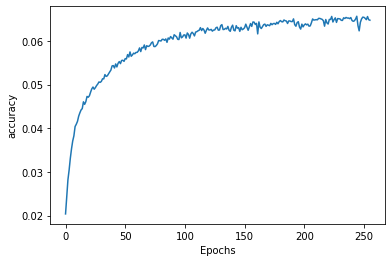

In [48]:
plot_graphs(history, 'accuracy')


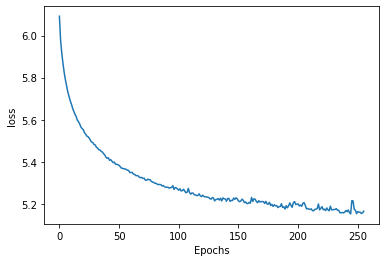

In [49]:
plot_graphs(history, 'loss')

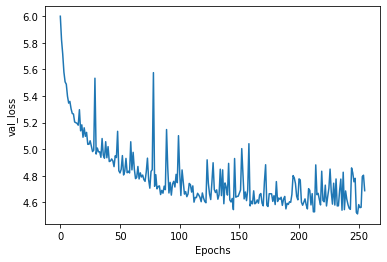

In [50]:
plot_graphs(history, 'val_loss')

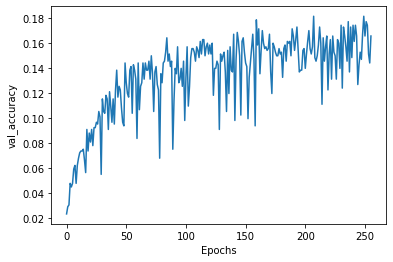

In [51]:
plot_graphs(history, 'val_accuracy')

In [52]:
def get5TopPredict(predict):
    predicts = predict[0].argsort()[-5:][::-1]
    for i in predicts:
        print(sortedClassContents[i])
        

In [53]:
      
def predictDense(first):
    predict = model.predict([[sortedClassContents.index(first)]])
    get5TopPredict(predict)
    return sortedClassContents[np.argmax(predict[0])]


In [63]:
predictResult = predictDense(1506)
print(predictResult)

1589
1599
1795
1774
1609
1589


In [57]:
run_model = tf.function(lambda x: model(x))
# This is important, let's fix the input size.
concrete_func = run_model.get_concrete_function(
    tf.TensorSpec([1,6], model.inputs[0].dtype))

# model directory.
MODEL_DIR = "model"
model.save(MODEL_DIR, save_format="tf", signatures=concrete_func)


ValueError: in user code:

    <ipython-input-57-742b1435b3ff>:1 None  *
        run_model = tf.function(lambda x: model(x))
    /home/ade/.local/lib/python3.8/site-packages/tensorflow/python/keras/engine/base_layer.py:975 __call__  **
        input_spec.assert_input_compatibility(self.input_spec, inputs,
    /home/ade/.local/lib/python3.8/site-packages/tensorflow/python/keras/engine/input_spec.py:212 assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer sequential_4 is incompatible with the layer: expected axis -1 of input shape to have value 1 but received input with shape [1, 6]


In [58]:
MODEL_DIR = "model"
model.save(MODEL_DIR) 

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: model/assets


In [59]:
converter = tf.lite.TFLiteConverter.from_saved_model(MODEL_DIR)
tflite_model = converter.convert()

In [ ]:
# Run the model with TensorFlow to get expected results.
TEST_CASES = 10

# Run the model with TensorFlow Lite
interpreter = tf.lite.Interpreter(model_content=tflite_model)
interpreter.allocate_tensors()
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()
print(input_details)
print(output_details)
print(input_details[0]["index"])
for i in range(TEST_CASES):
  expected = model.predict([[i]])
  interpreter.set_tensor( input_details[0]["index"], np.array([[i]]).astype(np.float32))
  interpreter.invoke()
  result = interpreter.get_tensor(output_details[0]["index"])

  # Assert if the result of TFLite model is consistent with the TF model.
  np.testing.assert_almost_equal(expected, result)
  print("Done. The result of TensorFlow matches the result of TensorFlow Lite.")

  # Please note: TfLite fused Lstm kernel is stateful, so we need to reset
  # the states.
  # Clean up internal states.
  interpreter.reset_all_variables()


In [60]:
open("tf_model/converted_model.tflite", "wb").write(tflite_model)

23853696

In [ ]:
interpreter.set_tensor( input_details[0]["index"], np.array([[sortedClassContents.index(700)]]).astype(np.float32))
interpreter.invoke()
result = interpreter.get_tensor(output_details[0]["index"])
print(sortedClassContents[np.argmax(result)])